**Временной ряд** - это последовательность значений, оисывающих протекающий во времени процесс, измеренных в последовательные поменты времени, обычно через равные промежутки.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
ads = pd.read_csv('datasets/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('datasets/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [5]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


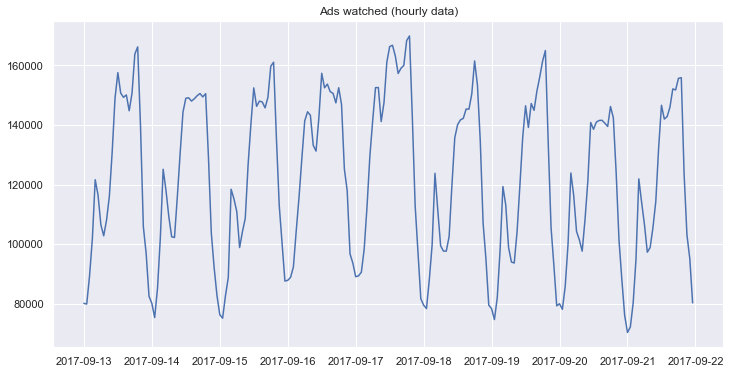

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [7]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


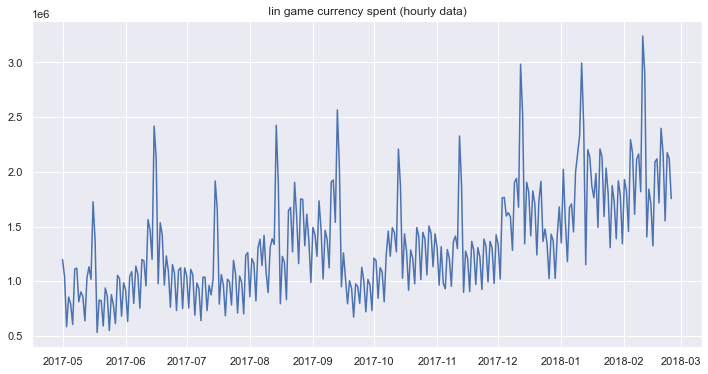

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Iin game currency spent (hourly data)')
plt.grid(True)
plt.show()

# Метрики качества прогноза

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination), коэффициент детерминации (в эконометрике - доля объясненной моделью дисперсии), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [9]:
# Импортируем всё, о чем говорили раньше

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_percentage_error

In [10]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (pas 24 hours)

116805.0

In [11]:
def  plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15, 5))
    plt.title(f'Moving average\n window size = {window}')
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    # Plot confidence intervals for smothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, 'r--', label='Upper Bond / Lower Bond')
        plt.plot(lower_bond, 'r--')
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, 'ro', markersize=10)
    
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='upper left')
    plt.grid(True)

 Применим такое сглаживание к нашим рядам: <br>
 Сглаживание по последним 4 часам

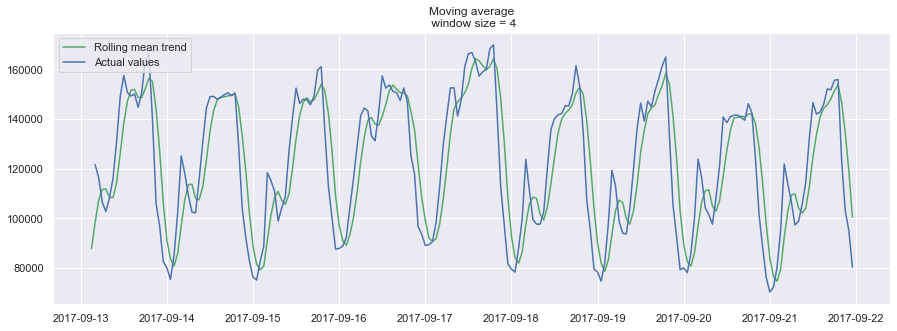

In [12]:
plot_moving_average(ads, 4)

По 12 часам (полдня)

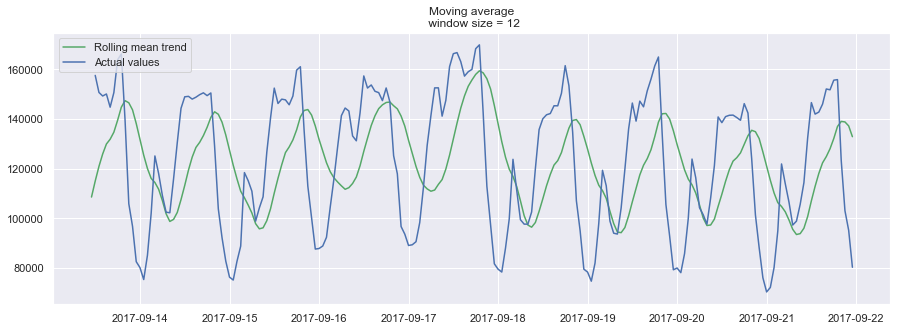

In [13]:
plot_moving_average(ads, 12)

Сглаживание по 24 часам (одни сутки) - выделяется дневной тренд

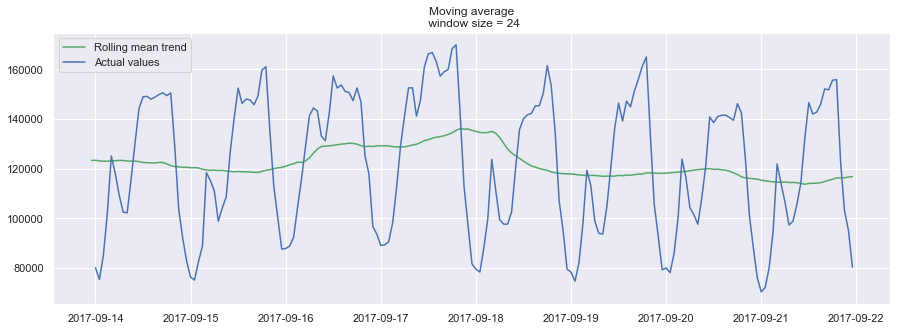

In [14]:
plot_moving_average(ads, 24)

Так же можно отобразить доверительные интервалы для наших средних значений

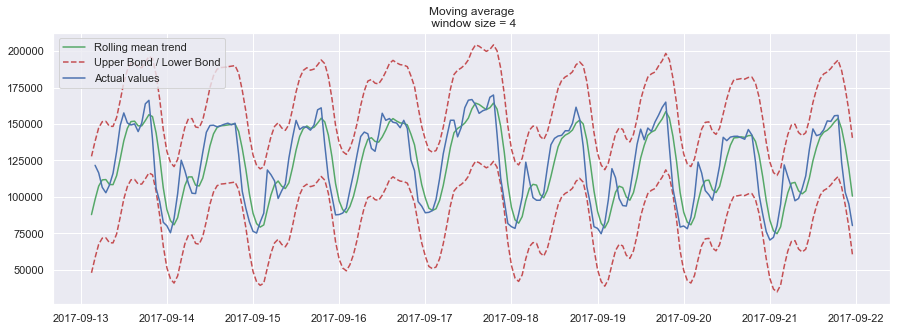

In [15]:
plot_moving_average(ads, 4, plot_intervals=True)

А теперь попробуем при помощи этих доверителных интервалов поймать аномалию во временном ряде. К сожалению ил к счастью,
конкретно в этом ряду всё хорошо и гладко, поэтому аномальные значения мы зададим самостоятельно в датафрейме ads_anomaly

In [16]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * .2 # say we have 80% drop for ads

И посмотрим, удастся ли таким простым образом её поймать

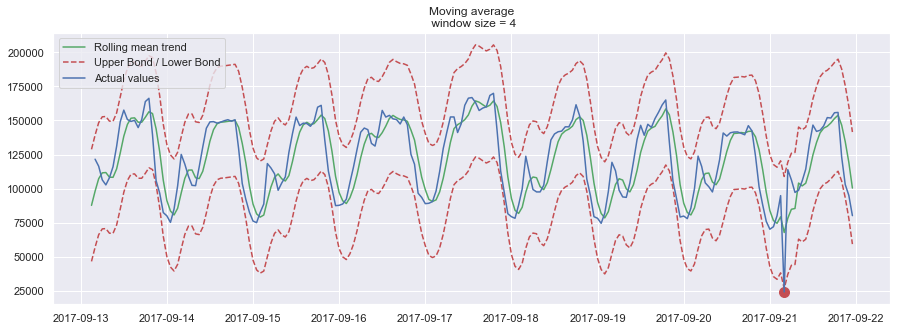

In [17]:
plot_moving_average(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

Тоже самое проделать и со вторым рядом, попробуем сгладить его с окном в 7 дней, то есть по неделям, и поймать аномалии

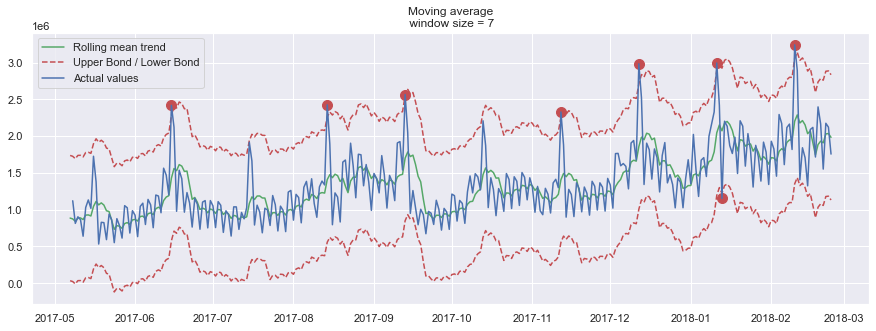

In [18]:
plot_moving_average(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

In [19]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [20]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

In [21]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is the same in series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [22]:
def plot_exponential_smoothing(series, alphas):
    """
        Plot exponential smoothing with different alphas
    
        series - dataset with timestamp
        alphas - list of floats, smoothing parameters
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label=f'Alpha {alpha}')
        plt.plot(series.values, 'c', label='Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True);

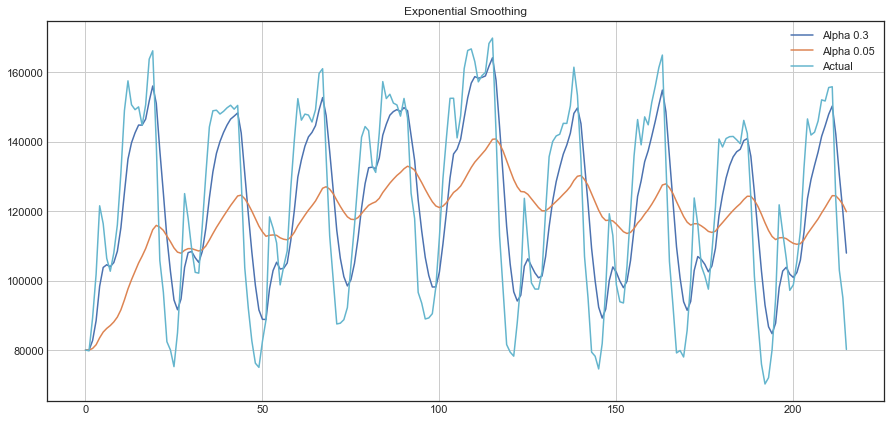

In [23]:
plot_exponential_smoothing(ads.Ads, [.3, .05])

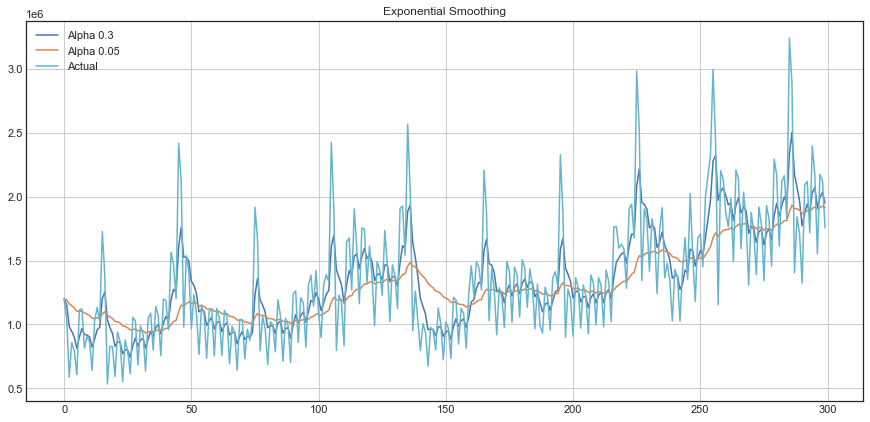

In [24]:
plot_exponential_smoothing(currency.GEMS_GEMS_SPENT, [.3, .05])

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [25]:
def  double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

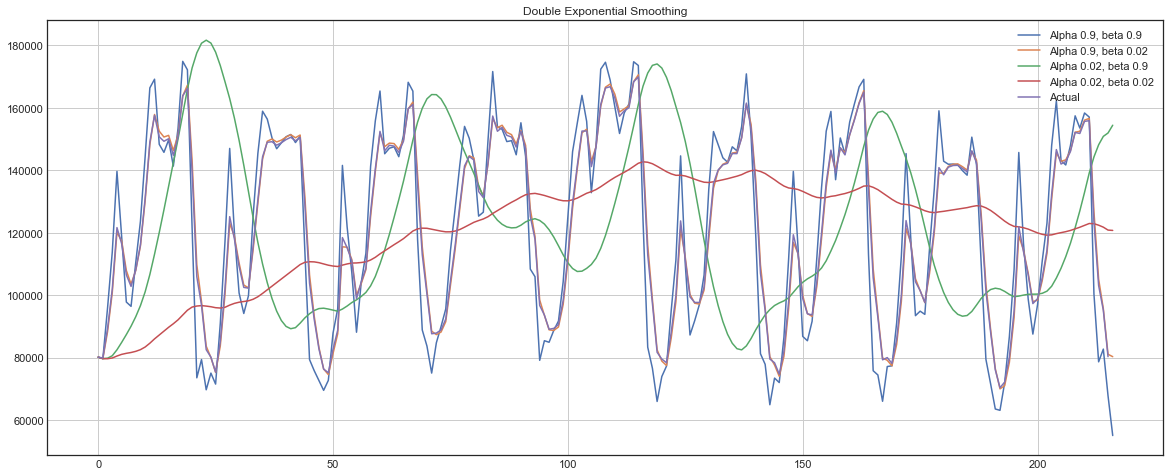

In [26]:
 plot_double_exponential_smoothing(ads.Ads, alphas=[.9, .02], betas=[.9, .02])

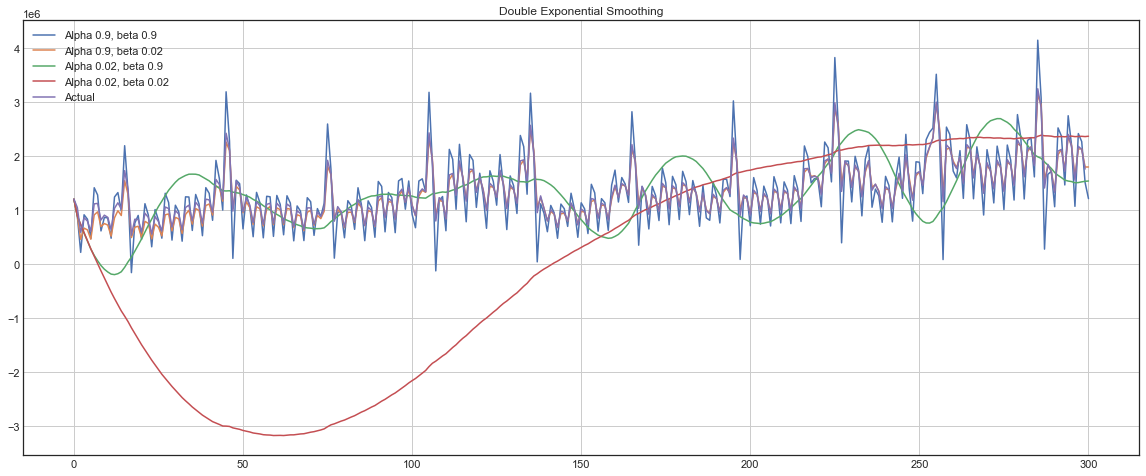

In [27]:
plot_double_exponential_smoothing(currency.GEMS_GEMS_SPENT, alphas=[.9, .02], betas=[.9, .02])

In [28]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

Теперь, зная, как настраивать кросс-валидацию, подберём с её помощью параметры для модели Хольта-Винтерса

In [29]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [30]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss functions
opt = minimize(timeseriesCVscore, x0=x,
               args=(data, mean_squared_error),
               method='TNC', bounds=((0, 1), (0, 1), (0, 1))
              )

# Take the optimal values
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ... and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen=24,
                    alpha = alpha_final,
                    beta = beta_final,
                    gamma = gamma_final,
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11469082908652417 0.002411065117098432 0.08737400521651173
Wall time: 4.35 s


In [31]:
def plot_holt_winters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = 'Model')
    plt.plot(series.values, label = 'Actual')
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title(f'Mean absolute percentage Error: {error:.2f}')
    
    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[:len(series)]] = \
            series.values[series.values < model.LowerBond[:len(series)]]
        anomalies[series.values > model.UpperBond[:len(series)]] = \
            series.values[series.values > model.UpperBond[:len(series)]]
        plt.plot(anomalies, 'o', markersize=10, label='Anomalies')
    
    if plot_intervals:
        plt.plot(model.UpperBond, 'r--', alpha=.5, label='Up/Low confidence')
        plt.plot(model.LowerBond, 'r--', alpha=.5)
        plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=.2, color='grey')
    
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series) - 20, len(model.result), alpha=.3, color='lightgray')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='best', fontsize=13);

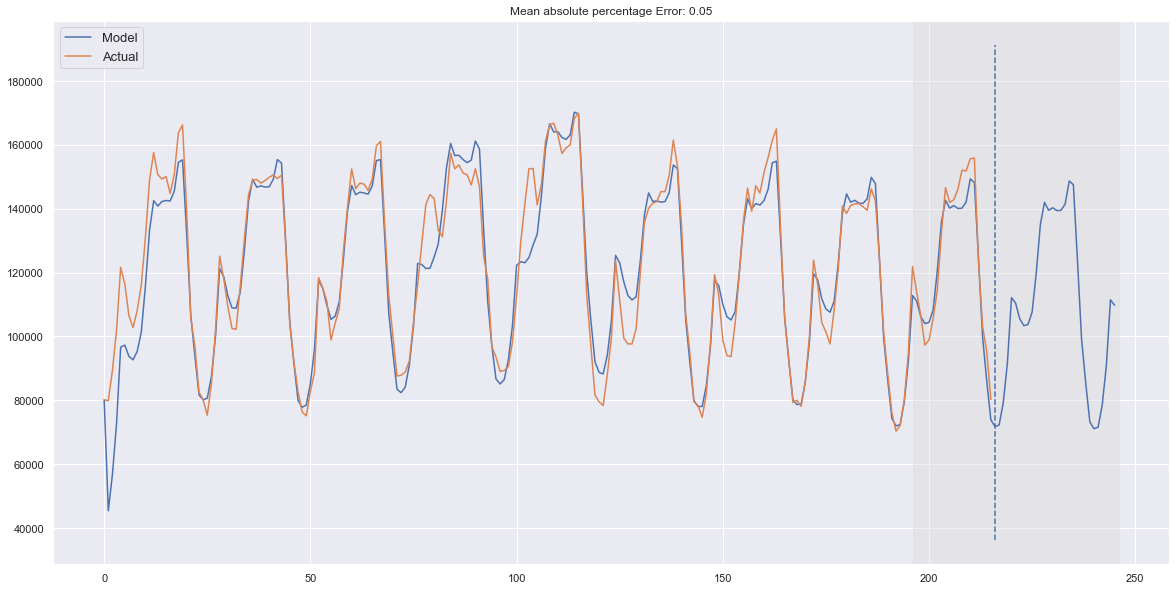

In [32]:
plot_holt_winters(ads.Ads)

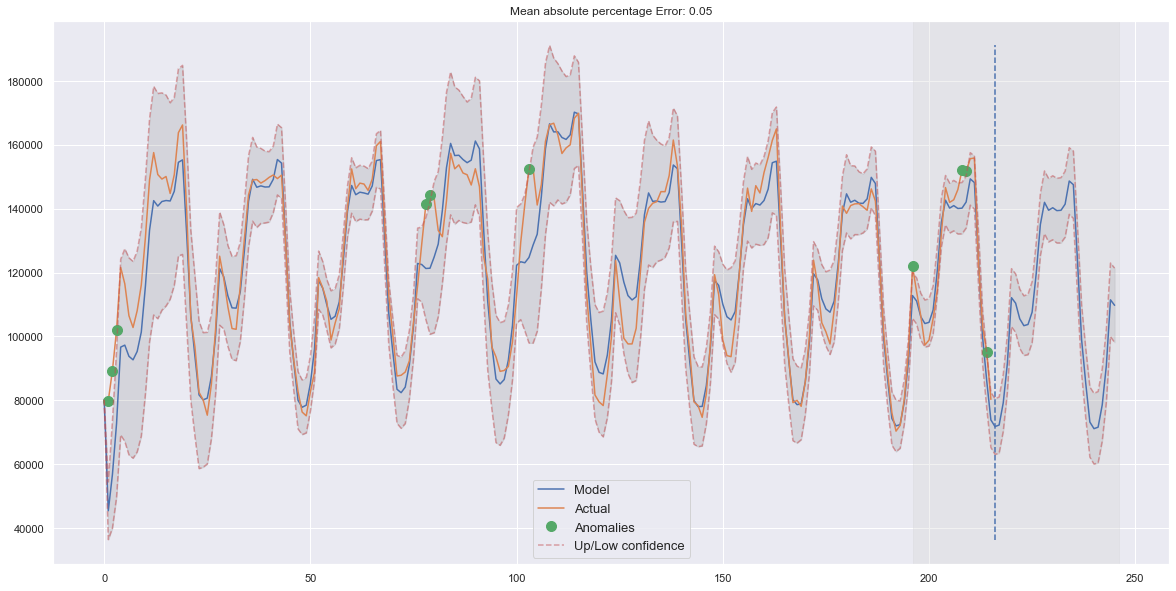

In [33]:
plot_holt_winters(ads.Ads, plot_intervals=True, plot_anomalies=True)

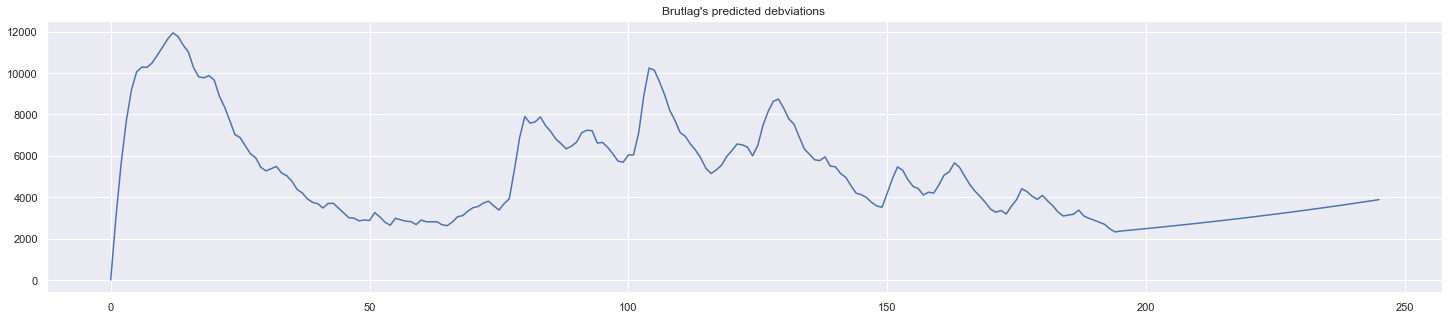

In [34]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title('Brutlag\'s predicted debviations ');

In [35]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] # leave some data for testing

slen = 30 # 30 day sesonality

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss functions
opt = minimize(timeseriesCVscore, x0=x,
               args=(data, mean_absolute_percentage_error, slen),
               method='TNC', bounds=((0, 1), (0, 1), (0, 1))
              )

# Take the optimal values
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ... and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen=slen,
                    alpha = alpha_final,
                    beta = beta_final,
                    gamma = gamma_final,
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.013270254679429161 0.04689448914982469 0.0
Wall time: 5.19 s


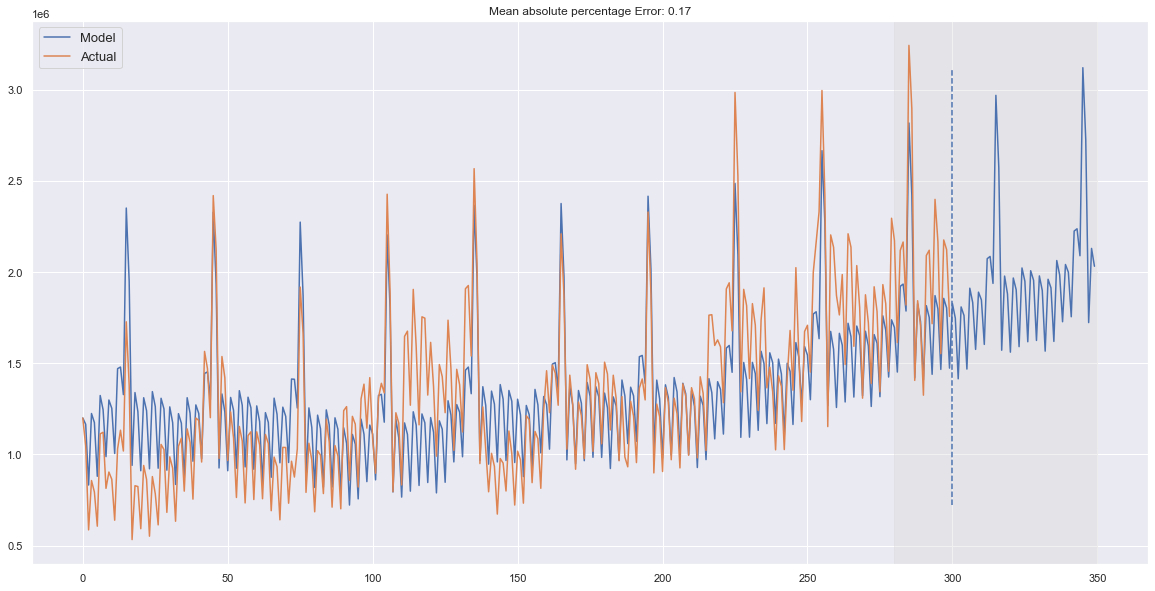

In [36]:
plot_holt_winters(currency.GEMS_GEMS_SPENT)

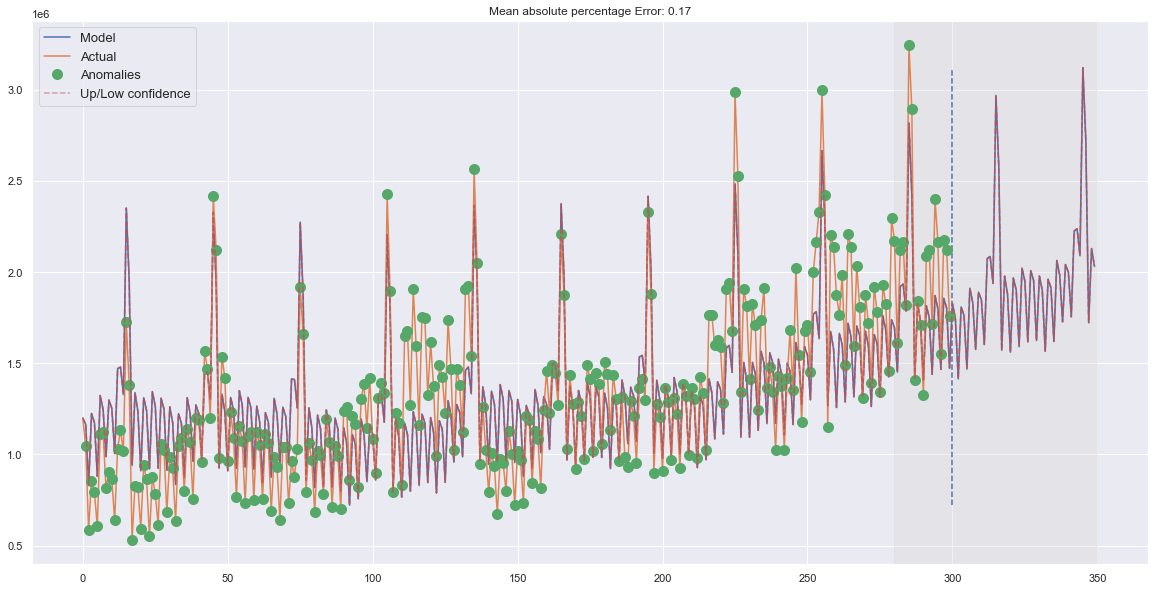

In [37]:
plot_holt_winters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

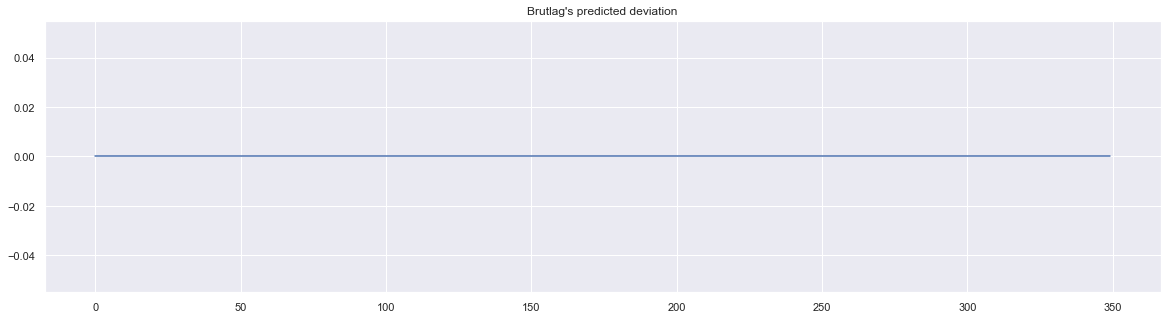

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title('Brutlag\'s predicted deviation');

**Стационарность**

График белого шума

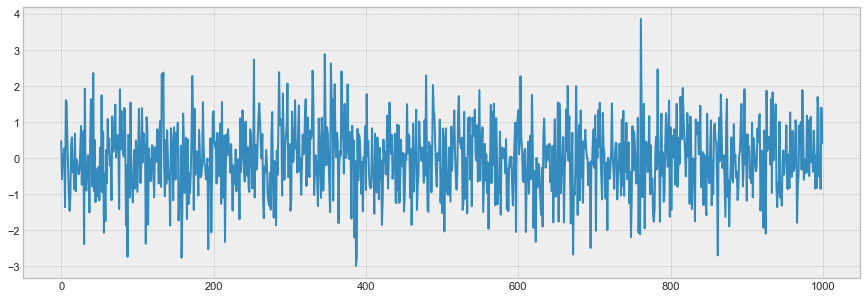

In [39]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля, с отклонением в 1. Теперь на основании него сгенерируем новый процесс, в котором каждое следующее значение буде зависеть от предыдущего: 
$x_1= \rho x_{t-1} + e_t$

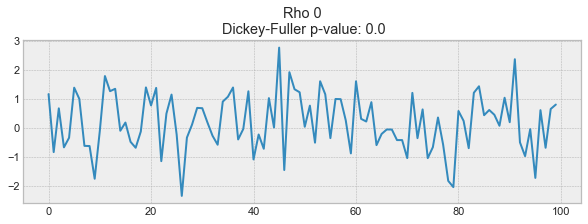

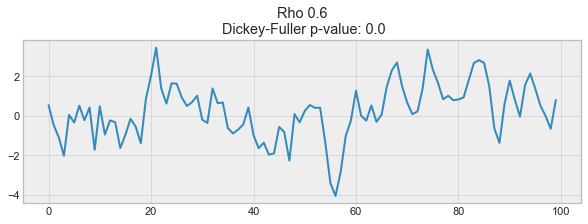

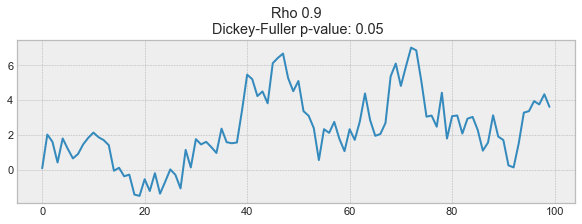

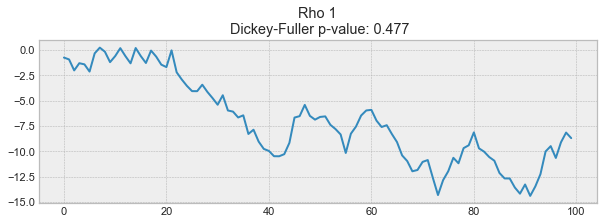

In [40]:
def plot_process(n_samples=100, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t - 1] + w[t]
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title(f'Rho {rho}\n Dickey-Fuller p-value: {round(sm.tsa.stattools.adfuller(x)[1], 3)}')

for rho in [0, .6, .9, 1]:
    plot_process(rho=rho)

# Избавляемся от нестационарности и строим SARIMA
Попробуем теперь построить SARIMA модель, пройдя вусе стадии приведения ряда к стационарному виду.

In [41]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

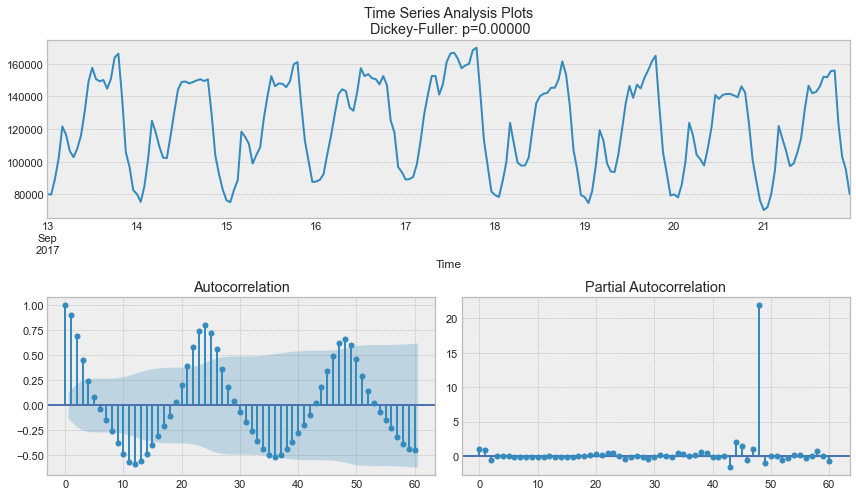

In [42]:
tsplot(ads.Ads, lags=60)

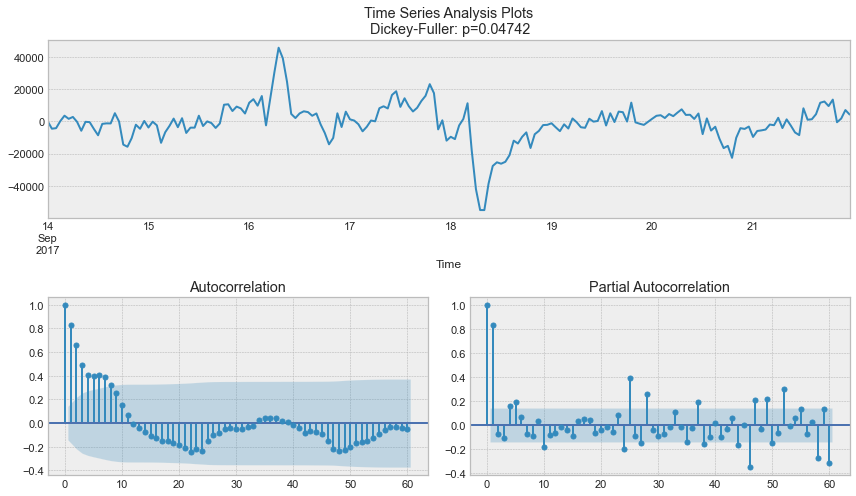

In [43]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

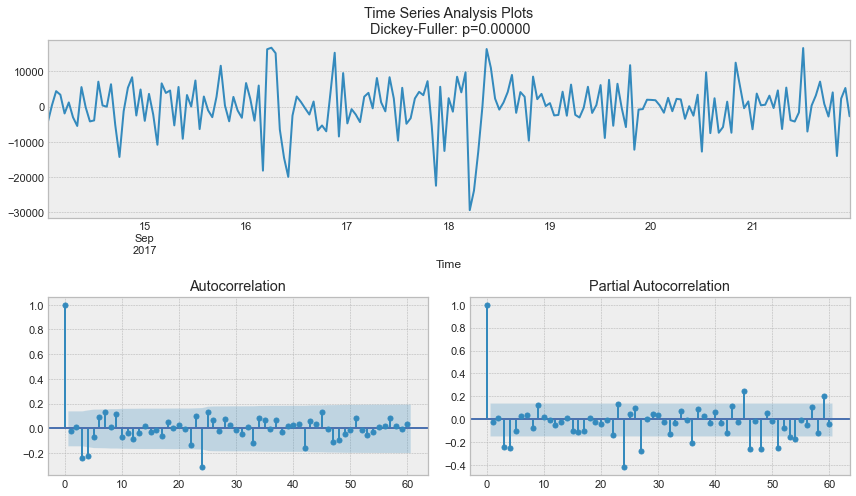

In [44]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

In [45]:
# p = 4
# d = 1
# q = 4

# P = 2
# D = 1
# Q = 1
# s = 24

Посмотрим, с какими параметрами модель будет лучше

In [46]:
# setting initial values and some bounds for them
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36